In [301]:
from pyprojroot import here
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.restoration import denoise_tv_chambolle
import matplotlib.pyplot as plt
import csv
import pprint

root = here()

In [318]:
data_path = root / "Microscopy/train"
raw_metadata_path = root / "Microscopy/train/meta.csv"

data_list = []
data_lists = {}

# open 10 images from meta.csv and display them
with open(raw_metadata_path, 'r') as f:
    # Create a csv reader object
    csv_reader = csv.reader(f)
    
    # Skip the header row
    next(csv_reader)

    for row in csv_reader:
        data_list.append(row)

        dose_Gy = float(row[1])
        particle_type = row[2]
        hr_post_exposure = int(row[3])

        if not (dose_Gy, hr_post_exposure, particle_type) in data_lists:
            data_lists[(dose_Gy, hr_post_exposure, particle_type)] = []
            
        data_lists[(dose_Gy, hr_post_exposure, particle_type)].append(row[0])

In [319]:
for key in data_lists:
    print(key, len(data_lists[key]))

(0.82, 4, 'Fe') 4416
(0.3, 4, 'Fe') 4582
(0.0, 4, 'Fe') 4632
(0.82, 24, 'Fe') 4515
(0.3, 24, 'Fe') 4668
(0.0, 24, 'Fe') 4651
(0.82, 48, 'Fe') 4593
(0.0, 48, 'Fe') 4507
(0.0, 4, 'X-ray') 4803
(0.1, 4, 'X-ray') 4726
(1.0, 4, 'X-ray') 4450
(0.0, 24, 'X-ray') 4437
(0.1, 24, 'X-ray') 4408
(1.0, 24, 'X-ray') 4519
(0.0, 48, 'X-ray') 4448
(0.1, 48, 'X-ray') 4451
(1.0, 48, 'X-ray') 4371


In [296]:
def count_foci(img_key):
    # Load the image using PIL
    img = Image.open(img_key)
    img_array = np.array(img)*5

    # Normalize the pixel values to the range of 0-255
    image_normalized = (img - np.min(img)) * (255 / (np.max(img) - np.min(img)))
    image_normalized = image_normalized.astype(np.uint8)

    # Convert the normalized array back to PIL Image
    image_normalized_pil = Image.fromarray(image_normalized)

    # Apply a sharpening filter
    sharpened_image = image_normalized_pil.filter(ImageFilter.UnsharpMask(radius=10, percent=5000, threshold=70))
    sharpened_image = np.array(sharpened_image)

    # Denoise the sharpened image using TVD algorithm
    denoised_array = denoise_tv_chambolle(sharpened_image, weight=0.5)
    denoised_image = Image.fromarray(denoised_array)
    denoised_image = np.array(denoised_image)

    # Apply a threshold to segment the image
    threshold_value = 100  # Adjust this threshold value as needed
    binary_image = denoised_image*255 > threshold_value

    # Apply distance transformation to find the distance of each pixel to the nearest background pixel
    distance_transform = ndi.distance_transform_edt(binary_image)

    # Identify the local maxima in the distance transformed image as markers for watershed segmentation
    coordinates = peak_local_max(distance_transform, min_distance=1)
    mask = np.zeros(distance_transform.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)

    # Perform watershed segmentation
    segmentation = watershed(-distance_transform, markers, mask=binary_image)

    # Count the number of foci (regions) detected
    num_foci = 0

    # Get region properties of the segmented regions
    regions = regionprops(segmentation)

    # Draw bounding boxes around the foci
    margin = 5

    for region in regions:
        minr, minc, maxr, maxc = region.bbox

        # Add margin around the bounding box
        minr = max(0, minr - margin)
        minc = max(0, minc - margin)
        maxr = min(segmentation.shape[0], maxr + margin)
        maxc = min(segmentation.shape[1], maxc + margin)

        # Only draw the bounding boxes for the foci that are larger than 40 pixels
        if (maxr - minr <= 40) and (maxc - minc <= 40):
            num_foci += 1
    
    return num_foci

In [ ]:
foci_count = {}

# Get the average number of foci for each condition
for key in data_lists:
    # Get the number of foci for first 100 images
    for img_key in data_lists[key][:200]:
        num_foci = count_foci(data_path / img_key)
        if key not in foci_count:
            foci_count[key] = []
        foci_count[key].append(num_foci)

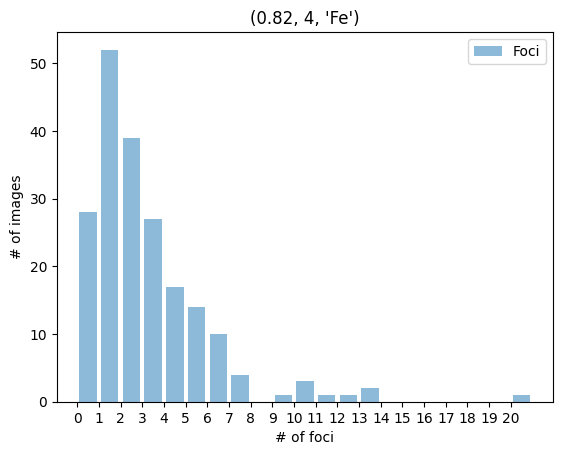

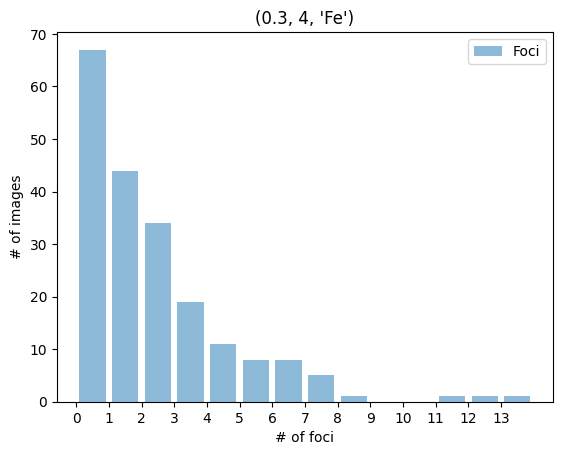

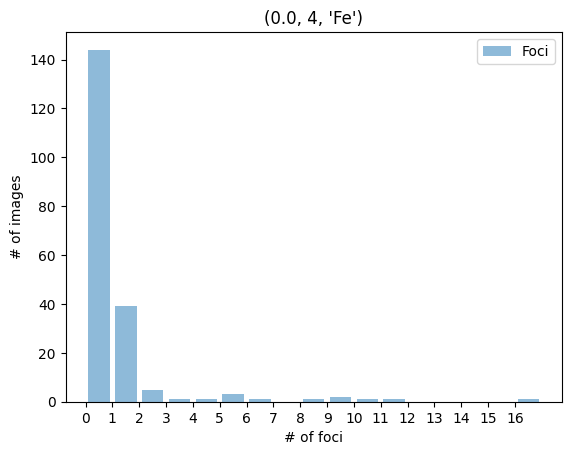

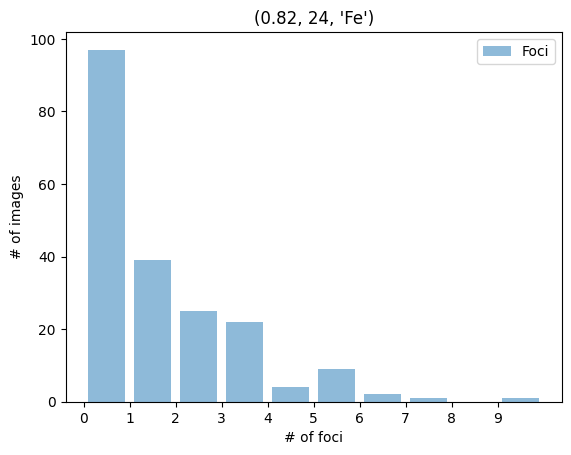

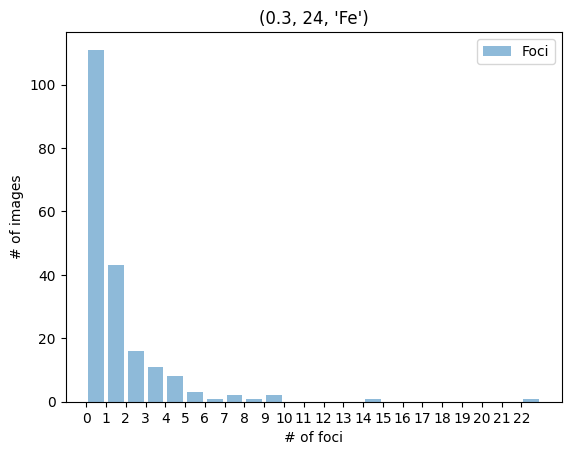

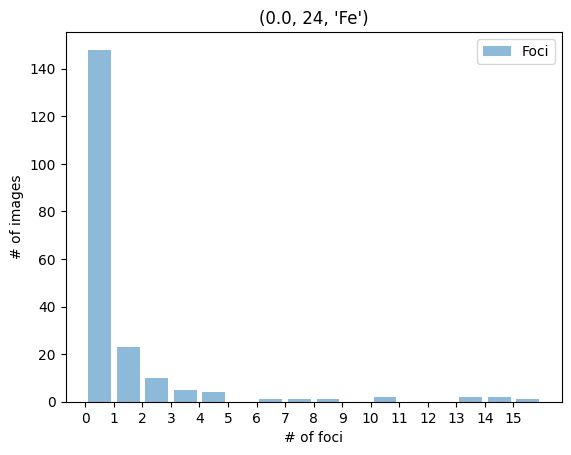

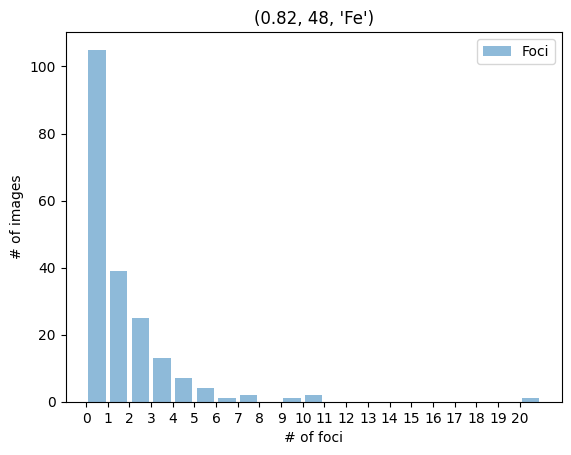

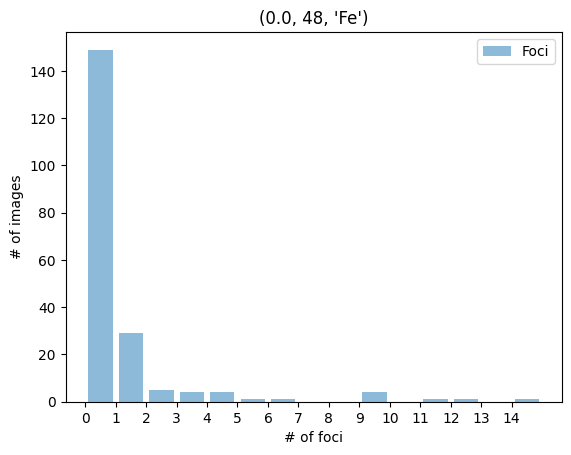

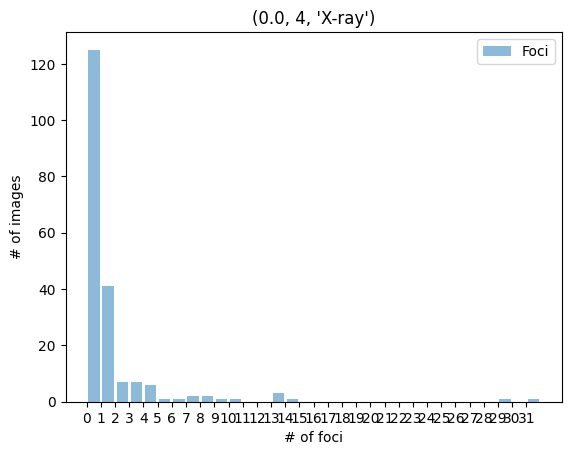

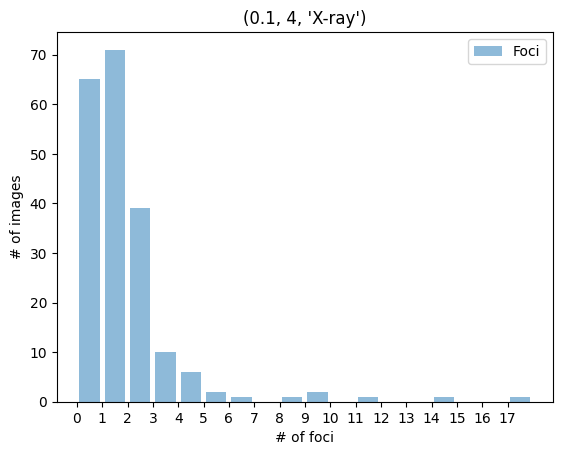

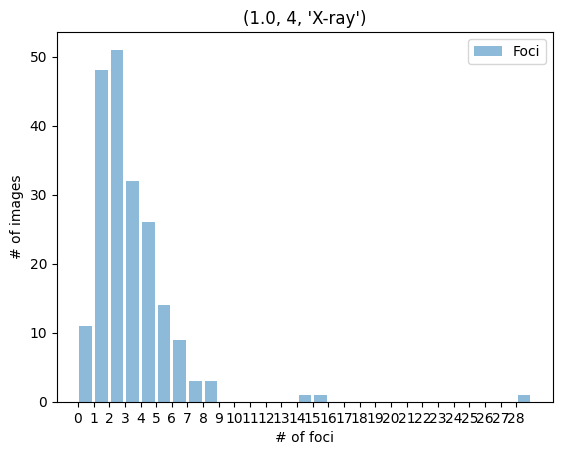

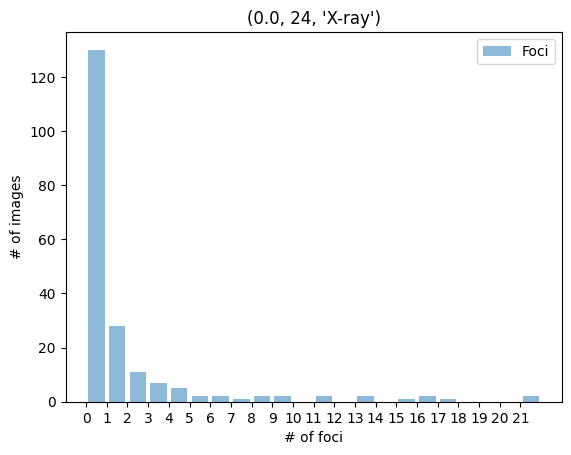

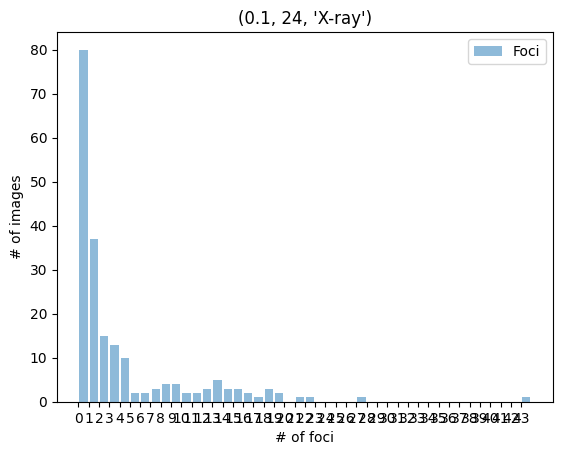

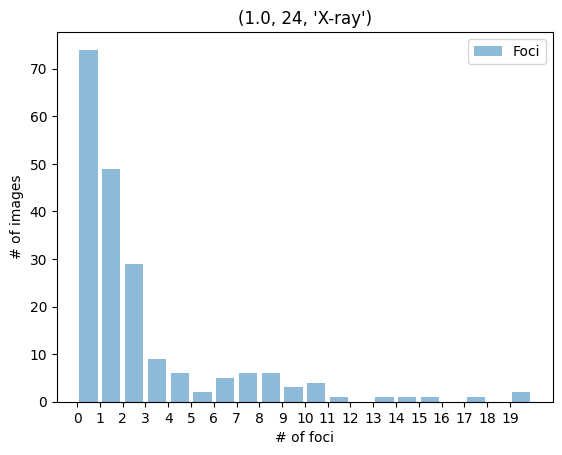

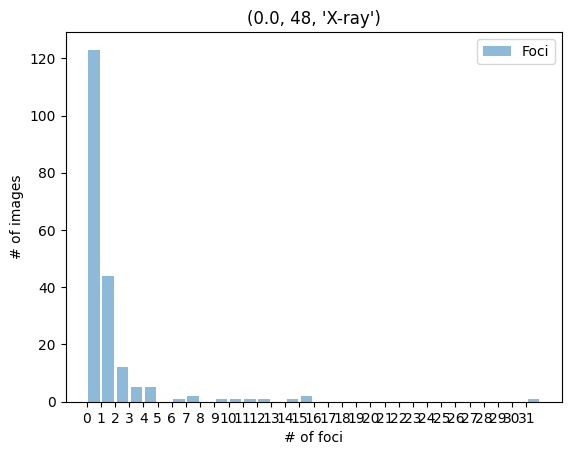

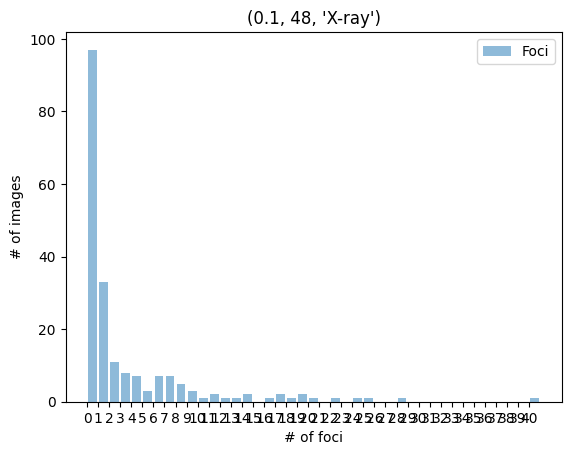

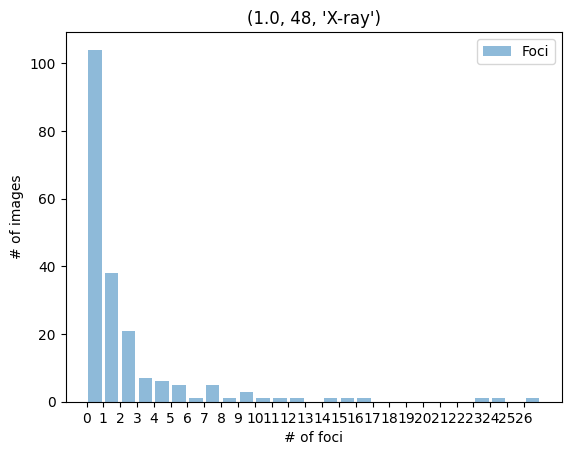

In [337]:
# create histogram for each condition
for key in foci_count:
    plt.hist(foci_count[key], bins=range(min(foci_count[key]), max(foci_count[key]) + 2), alpha=0.5, label="Foci", rwidth=0.8)
    plt.xticks(range(min(foci_count[key]), max(foci_count[key]) + 1))
    plt.legend(loc="upper right")
    plt.title(key)
    plt.xlabel("# of foci")
    plt.ylabel("# of images")
    plt.show()

In [ ]:
for i in range(100):
    img_key = data_path / data_lists[(1.0, 24, 'X-ray')][i]

    # Load the image using PIL
    img = Image.open(img_key)
    img_array = np.array(img)*5

    # Normalize the pixel values to the range of 0-255
    image_normalized = (img - np.min(img)) * (255 / (np.max(img) - np.min(img)))
    image_normalized = image_normalized.astype(np.uint8)

    # Convert the normalized array back to PIL Image
    image_normalized_pil = Image.fromarray(image_normalized)

    # Apply a sharpening filter
    sharpened_image = image_normalized_pil.filter(ImageFilter.UnsharpMask(radius=10, percent=5000, threshold=70))
    sharpened_image = np.array(sharpened_image)

    # Denoise the sharpened image using TVD algorithm
    denoised_array = denoise_tv_chambolle(sharpened_image, weight=0.5)
    denoised_image = Image.fromarray(denoised_array)
    denoised_image = np.array(denoised_image)

    # Apply a threshold to segment the image
    threshold_value = 100  # Adjust this threshold value as needed
    binary_image = denoised_image*255 > threshold_value

    # Apply distance transformation to find the distance of each pixel to the nearest background pixel
    distance_transform = ndi.distance_transform_edt(binary_image)

    # Identify the local maxima in the distance transformed image as markers for watershed segmentation
    coordinates = peak_local_max(distance_transform, min_distance=1)
    mask = np.zeros(distance_transform.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)

    # Perform watershed segmentation
    segmentation = watershed(-distance_transform, markers, mask=binary_image)

    # Count the number of foci (regions) detected
    num_foci = 0

    # Get region properties of the segmented regions
    regions = regionprops(segmentation)

    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # Draw bounding boxes around the foci
    margin = 5

    for region in regions:
        minr, minc, maxr, maxc = region.bbox

        # Add margin around the bounding box
        minr = max(0, minr - margin)
        minc = max(0, minc - margin)
        maxr = min(segmentation.shape[0], maxr + margin)
        maxc = min(segmentation.shape[1], maxc + margin)

        # Only draw the bounding boxes for the foci that are larger than 40 pixels
        if (maxr - minr <= 40) and (maxc - minc <= 40):
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='w', linewidth=2, alpha=0.5)
            plt.gca().add_patch(rect)
            num_foci += 1

    # Display images
    ax1.imshow(img)
    ax1.title.set_text('Original image')
    ax2.imshow(sharpened_image)
    ax2.title.set_text('Sharpened image')
    ax3.imshow(denoised_image)
    ax3.title.set_text('Foci count: ' + str(num_foci))

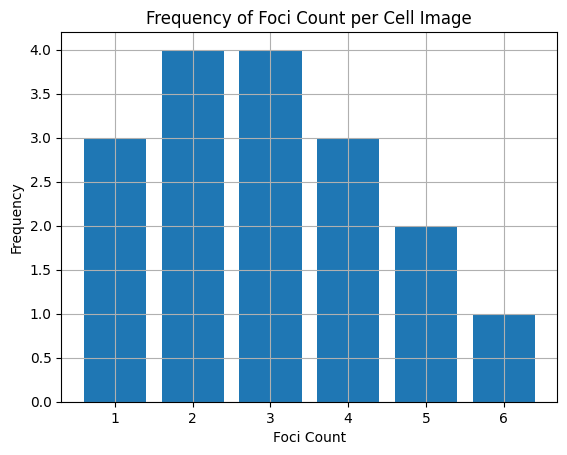

In [314]:
# Example foci count data
foci_counts = [3, 2, 5, 4, 2, 1, 3, 4, 2, 1, 3, 4, 5, 6, 3, 2, 1]

# Plot histogram
plt.hist(foci_counts, bins=range(min(foci_counts), max(foci_counts) + 2), align='left', rwidth=0.8)
plt.xticks(range(min(foci_counts), max(foci_counts) + 1))
plt.xlabel('Foci Count')
plt.ylabel('Frequency')
plt.title('Frequency of Foci Count per Cell Image')
plt.grid(True)

# Show the plot
plt.show()